# **Aggregation function**



Import necessary functions

In [1]:
# Load libraries

import torch
import numpy as np
from torchvision import models
import glob # for listing files in the directory, asemejan un patrón especificado de acuerdo con las reglas de coincidencia de Unix
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import transforms
from multiprocessing import Pool
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
import cv2
import pathlib
import os

In [2]:
torch.cuda.empty_cache()

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device) # If gpu is available, cuda will be printed

cuda


Define the architectures used for each model

In [3]:
# Convoloitional neural network
class ConvNet(nn.Module):

    def __init__(self, num_classes = 2):
        super(ConvNet, self).__init__()

        """ 

        Output size after convolutional filter:
        ((input_size - kernel + 2 * padding)/ stride) + 1
        
        """

        # Input shape = (3, 224, 224)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        # Shape = (16, 224, 224) -- Same shape as input, but more channels
        # Add batch normalization
        self.bn1 = nn.BatchNorm2d(num_features=16) # Shape = (16, 224, 224)
        # Add activation function
        self.relu1 = nn.ReLU() # Shape = (16, 224, 224)
        # Max pool 1, reuduce the image size be factor 2
        self.pool1 = nn.MaxPool2d(kernel_size=2) # Shape = (16, 112, 112)

        # Add second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Shape = (32, 112, 112)
        # Add activation function
        self.relu2 = nn.ReLU() # Shape = (32, 112, 112)

        # Add third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # Shape = (64, 112, 112)
        # Add batch normalization
        self.bn3 = nn.BatchNorm2d(num_features=64) # Shape = (64, 112, 112)
        # Add activation function
        self.relu3 = nn.ReLU() # Shape = (64, 112, 112)

        # Linear layer (64 * 112 * 112 -> 2)
        self.fc = nn.Linear(in_features=64 * 112 * 112, out_features=num_classes)

    # Feed forward function
    def forward(self, input):
        # Convolutional layer
        output = self.conv1(input)
        # Batch normalization
        output = self.bn1(output)
        # Activation function
        output = self.relu1(output)
        # Max pool
        output = self.pool1(output)

        # Convolutional layer
        output = self.conv2(output)
        # Activation function
        output = self.relu2(output)

        # Convolutional layer
        output = self.conv3(output)
        # Batch normalization
        output = self.bn3(output)
        # Activation function
        output = self.relu3(output)

        # Above output will be in matrix form with shape (64, 112, 112)

        # Flatten
        output = output.view(-1, 64 * 112 * 112)

        # Linear layer (output -> 2)
        output = self.fc(output)

        return output   

In [4]:
class AutoEncoderHPyloris(nn.Module):
    def __init__(self):
        super(AutoEncoderHPyloris, self).__init__()
        
        """
        The proposed autoencoder has 3 convolutional blocks with one convolutional layer,
        batch normalization and leakyrelu activation each. The size of the convolutional
        kernel is 3 and the number of neurons and stride of each layer are, respectively,
        [32,64,64] and [1,2,2].
        """
        
        self.encoder =  nn.Sequential(
                        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Convolutional Layer 1
                        nn.BatchNorm2d(32),  # Batch Normalization 1
                        nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU Activation 1
                       
                        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Convolutional Layer 2
                        nn.BatchNorm2d(64),  # Batch Normalization 2
                        nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU Activation 2

                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Convolutional Layer 3
                        nn.BatchNorm2d(128),  # Batch Normalization 3
                        nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU Activation 3
                        
                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Convolutional Layer 3
                        nn.BatchNorm2d(256),  # Batch Normalization 3
                        nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU Activation 3
                        
                        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),  # Convolutional Layer 3
                        nn.BatchNorm2d(256),  # Batch Normalization 3
                        nn.LeakyReLU(0.2, inplace=True)  # LeakyReLU Activation 3
        )
        
        self.decoder =  nn.Sequential(
                        nn.ConvTranspose2d(256, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.2, inplace=True),
            
                        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.2, inplace=True),
                        
                        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.2, inplace=True),
                        
                        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(0.2, inplace=True),
                        
                        nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1),
                        nn.LeakyReLU(0.2, inplace=True)
        )
        
    def forward(self, image):
        encoded_img = self.encoder(image)
        decoded_img = self.decoder(encoded_img)
        return decoded_img

In [5]:
modelVGG = models.vgg16(pretrained=True) # VGG model

/fhome/gia01/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/fhome/gia01/anaconda3/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [32]:
def predict_patch(model, image, transform, inverse_transform, threshold=0.25, device='cpu'):
    """
    Inputs:
        MODEL: AutoEncoder model, given an input image, returns the reconstructed image
        IMAGE: a 3 channel image that will be reconstructed
        TRANSFORM: transforms that will be applied to input image
        INVERSE_TRANSFORM: transforms that will be applied to reconstructed image
        THRESHOLD (default=0.25): the threshold that will classify the patch
        DEVICE (default='cpu'): device where the model will be loaded (cpu or cuda)
    Outputs:
        INFECTION: 0 if no infection, 1 if infection
    """

    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Apply the transformations to convert the PIL image to a PyTorch tensor
    image_tensor = transform(image).unsqueeze(0)
    
    # Move the tensor to the specified device
    image_tensor = image_tensor.to(device)
    
    model.eval()
    with torch.no_grad():
        model.to(device)
        #original = transform(image).unsqueeze(0)
        #original.to(device)
        reconstructed_image = inverse_transform(model(image_tensor).squeeze(0))

        hsv_original_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2HSV)
        red_pixels_original = np.sum(np.logical_or((hsv_original_image[:, :, 0] < 20) & (hsv_original_image[:, :, 0] >= 0),
                                            (hsv_original_image[:, :, 0] > 160) & (hsv_original_image[:, :, 0] <= 180)))
        percentage_original = 100 * (red_pixels_original / (224 * 224))
        
        hsv_reconstructed_image = cv2.cvtColor(np.array(reconstructed_image), cv2.COLOR_RGB2HSV)
        red_pixels_reconstructed = np.sum(np.logical_or((hsv_reconstructed_image[:, :, 0] < 20) & (hsv_reconstructed_image[:, :, 0] >= 0), 
                                                        (hsv_reconstructed_image[:, :, 0] > 160) & (hsv_reconstructed_image[:, :, 0] <= 180)))
        percentage_reconstructed = 100 * (red_pixels_reconstructed / (224 * 224))
        
        lost_pixels_ratio = percentage_original-percentage_reconstructed
        
        if lost_pixels_ratio >= threshold:
            return 1
        else:
            return 0

In [7]:
inverse_transform = transforms.Compose([transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                                                                std=[1/0.229, 1/0.224, 1/0.225]), 
                                        transforms.ToPILImage()])

Get the train set for the ensemble method training

In [21]:
# Initialize the dictionary to store the data
train_dict = {'INFECTED': {}, 'NOT_INFECTED': {}}

# Read the file line by line
with open('/fhome/gia01/vl_project2/autoencoder/txt files/train_thresholds.txt', 'r') as file:
    for line in file:
        # Strip any whitespace and split the line by comma
        parts = line.strip().split(',')
        # Assign the parts to variables for clarity
        sample_id, path, status = parts[0], parts[1], int(parts[2])
        # Depending on the status, add the entry to the respective dictionary key
        if status == 1:
            train_dict['INFECTED'][sample_id] = path
        else:
            train_dict['NOT_INFECTED'][sample_id] = path

# Now data_dict is populated with the data in the format you wanted.
print(train_dict)

{'INFECTED': {'B22-65': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-65_1/', 'B22-222': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-222_1/', 'B22-130': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-130_1/', 'B22-225': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-225_1/', 'B22-263': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-263_1/'}, 'NOT_INFECTED': {'B22-282': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-282_1/', 'B22-168': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-168_1/', 'B22-227': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-227_1/', 'B22-111': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-111_1/', 'B22-189': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-189_1/'}}


Get the test set for the final prediction

In [22]:
# Initialize the dictionary to store the data
test_dict = {'INFECTED': {}, 'NOT_INFECTED': {}}

# Read the file line by line
with open('/fhome/gia01/vl_project2/autoencoder/txt files/test_aggregate.txt', 'r') as file:
    for line in file:
        # Strip any whitespace and split the line by comma
        parts = line.strip().split(',')
        # Assign the parts to variables for clarity
        sample_id, path, status = parts[0], parts[1], int(parts[2])
        # Depending on the status, add the entry to the respective dictionary key
        if status == 1:
            test_dict['INFECTED'][sample_id] = path
        else:
            test_dict['NOT_INFECTED'][sample_id] = path

# Now data_dict is populated with the data in the format you wanted.
print(test_dict)

{'INFECTED': {'B22-272': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-272_1/', 'B22-286': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-286_1/', 'B22-293': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-293_1/', 'B22-294': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-294_1/', 'B22-295': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-295_1/'}, 'NOT_INFECTED': {'B22-28': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-28_1/', 'B22-34': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-34_1/', 'B22-53': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-53_1/', 'B22-87': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-87_1/', 'B22-112': '/fhome/mapsiv/QuironHelico/CroppedPatches/B22-112_1/'}}


*Load the three models used for the diagnosis: CNN, AE, VGG*

In [10]:
import pickle

# Load the checkpoint for the CNN model
checkpointCNN = torch.load("best_checkpoint1.model")

# Instantiate the CNN model and load the checkpoint into it
modelCNN = ConvNet(num_classes = 2)
modelCNN.load_state_dict(checkpointCNN)
modelCNN.to(device)
modelCNN.eval()

model_path = '/fhome/gia01/vl_project2/autoencoder/model_pkl/10_EPOCH_MSE_AE.pkl'
with open(model_path, 'rb') as weights:
    state = pickle.load(weights)
    modelAE = AutoEncoderHPyloris()
    modelAE.load_state_dict(state)
modelAE.to(device)    

checkpoint = torch.load("best_checkpoint.modelVGG") # Load checkpoint

modelVGG = models.vgg16(pretrained=True)
modelVGG.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)
modelVGG.load_state_dict(checkpoint) # Load checkpoint into the model
modelVGG.to(device)
modelVGG.eval() # Set model to evaluation mode


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
# Define data augmentation transforms
myTransforms = transforms.Compose([ transforms.Resize((224,224)), # Resize the image to 224x224
                                    transforms.ToTensor(),       # Convert the image to a tensor
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize the image
])

Optimal thresholds

In [12]:
CNN_threshold = 3 # CNN threshold
AE_threshold = 7 # AE threshold
VGG_threshold = 7 # VGG threshold

Prediction function

In [13]:
def prediction(img_path, myTransforms, model):
    # Load the image
    image = Image.open(img_path)

    # Convert RGBA to RGB if necessary
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    # Apply the transformations
    image_tensor = myTransforms(image).unsqueeze(0)  # Add batch dimension

    # Move the model and tensor to the same device
    device = next(model.parameters()).device  # Get the device from the model
    image_tensor = image_tensor.to(device)

    # Forward pass through the model to get the predictions
    output = model(image_tensor)

    # Move the output back to CPU and convert to numpy array for further processing
    output = output.cpu().data.numpy()

    # Get the index of the highest probability class
    index = output.argmax()

    return index


In [14]:
# Declaration of the function in order to make the conversion
def calculate_confidence(percentage, threshold):
    """
    Calculate the confidence level based on a given percentage using a rule of three.

    Parameters:
    percentage (float): A percentage value where 0.1 maps to a confidence level of 1.

    Returns:
    float: The calculated confidence level, capped at 1 for percentages over 0.1.
    """
    # If the percentage is greater than 0.1, the confidence is 1
    if percentage >= threshold:
        return 1
    else:
        # Otherwise, scale the confidence linearly from 0 to 1 as the percentage goes from 0 to 0.1
        # Using the rule of three: percentage / 0.1 = confidence / 1
        confidence = percentage / threshold
        return confidence

Predictions

In [23]:
y_scoresCNN = list() # Store the probability estimates of being from the infected class, threshold: %3
y_scoresAE = list() # Store the probability estimates of being from the infected class, threshold: %int()
y_scoresVGG = list() # Store the probability estimates of being from the infected class, threshold: %int()

infectedPer_listCNN = list() # Store the infected percentage for each patient
infectedPer_listAE = list() # Store the infected percentage for each patient
infectedPer_listVGG = list() # Store the infected percentage for each patient

y_test = list() # Store the ground truth from the data, infected or not infected

i = 0 # Counter

# Iterate over the test set
for label in train_dict:

    patients_dict = train_dict[label] # Get the dictionary of the patients

    # Determine ground truth
    if (label == "INFECTED"): # Infected
        gt = 1
    
    else: # Not infected
        gt = 0

    # Iterate over the patients
    for patient in patients_dict:

        patient_predictionsCNN = list() # Initialize the data structure in which the prediction for a particular patient will be stored
        patient_predictionsAE = list() # Initialize the data structure in which the prediction for a particular patient will be stored
        patient_predictionsVGG = list() # Initialize the data structure in which the prediction for a particular patient will be stored
        # Get a list of all the full paths for the images from the patient
        images_files_full_paths = [os.path.join(patients_dict[patient], file) for file in os.listdir(patients_dict[patient])]
        
        # Iterate over all the images of the patient
        for image_path in images_files_full_paths:

            predCNN = prediction(image_path, myTransforms, modelCNN) # Get the prediction for the patch
            patient_predictionsCNN.append(predCNN) # Append the prediction

            imageAE = Image.open(image_path) # Open image with PIL
            predAE = predict_patch(modelAE, imageAE, transform = myTransforms, inverse_transform = inverse_transform, threshold=0.25, device='cpu') # Get the prediction for the patch
            patient_predictionsAE.append(predAE) # Append the prediction

            predVGG = prediction(image_path, myTransforms, modelVGG) # Get the prediction for the patch
            patient_predictionsVGG.append(predVGG) # Append the prediction

        value = 1 # Infected class

        # Calculate the percentage of infected detected patches for a particular patient
        infected_percentageCNN = patient_predictionsCNN.count(value) / len(patient_predictionsCNN)
        infectedPer_listCNN.append(infected_percentageCNN)

        # Calculate the percentage of infected detected patches for a particular patient
        infected_percentageAE = patient_predictionsAE.count(value) / len(patient_predictionsAE)
        infectedPer_listAE.append(infected_percentageAE)

        # Calculate the percentage of infected detected patches for a particular patient
        infected_percentageVGG = patient_predictionsVGG.count(value) / len(patient_predictionsVGG)
        infectedPer_listVGG.append(infected_percentageVGG)

        # Calculate the estimated probability of the model based on predefined criterion for the diagnosis
        # += threshold of infected patches in a patient - estimated probability of infection: 100%
        # 0% of infected patches in a patient - estimated probability of infection: 0%
        y_scoreCNN = calculate_confidence(infected_percentageCNN, 0.03) # Threshold: %3
        y_scoreAE = calculate_confidence(infected_percentageAE, 0.07) # Threshold: %
        y_scoreVGG = calculate_confidence(infected_percentageVGG, 0.07) # Threshold: %
        
        
        # Update y_score and y_test lists
        y_scoresCNN.append(y_scoreCNN)
        y_scoresAE.append(y_scoreAE)
        y_scoresVGG.append(y_scoreVGG)

        y_test.append(gt) # Ground truth

        i += 1
        print("Patient", str(i) + ":", "for CNN  |", gt, "-", round(y_scoreCNN, 3))
        print("Patient", str(i) + ":", "for AE   |", gt, "-", round(y_scoreAE, 3))
        print("Patient", str(i) + ":", "for VGG  |", gt, "-", round(y_scoreVGG, 3))
        print()
        
        # print(y_scores) # Display scores
        # print(y_test) # Display ground truth

        # Update control data structure
        # CNN_predictions.append((str(patient), [gt, y_score]))

Patient 1: for CNN  | 1 - 1
Patient 1: for AE   | 1 - 0.038
Patient 1: for VGG  | 1 - 1

Patient 2: for CNN  | 1 - 1
Patient 2: for AE   | 1 - 0.0
Patient 2: for VGG  | 1 - 1

Patient 3: for CNN  | 1 - 1
Patient 3: for AE   | 1 - 0.03
Patient 3: for VGG  | 1 - 1

Patient 4: for CNN  | 1 - 1
Patient 4: for AE   | 1 - 0.015
Patient 4: for VGG  | 1 - 1

Patient 5: for CNN  | 1 - 1
Patient 5: for AE   | 1 - 0.0
Patient 5: for VGG  | 1 - 1

Patient 6: for CNN  | 0 - 0.055
Patient 6: for AE   | 0 - 0.0
Patient 6: for VGG  | 0 - 0.213

Patient 7: for CNN  | 0 - 0.325
Patient 7: for AE   | 0 - 0.0
Patient 7: for VGG  | 0 - 0.41

Patient 8: for CNN  | 0 - 0.07
Patient 8: for AE   | 0 - 0.0
Patient 8: for VGG  | 0 - 0.127

Patient 9: for CNN  | 0 - 0.659
Patient 9: for AE   | 0 - 0.0
Patient 9: for VGG  | 0 - 0.242

Patient 10: for CNN  | 0 - 0.221
Patient 10: for AE   | 0 - 0.0
Patient 10: for VGG  | 0 - 0.261



In [26]:
binary_labelsCNN = [1 if prob >= 0.5 else 0 for prob in y_scoresCNN] # Threshold: %3
binary_labelsAE = [1 if prob >= 0.5 else 0 for prob in y_scoresAE] # Threshold: %int()
binary_labelsVGG = [1 if prob >= 0.5 else 0 for prob in y_scoresVGG] # Threshold: %int()

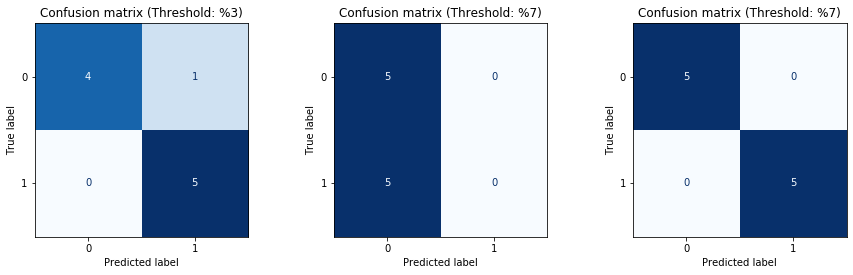

In [27]:
# Assuming you have binary_labels0025, binary_labels0035, binary_labels004, binary_labels005, etc. already defined
# Define the thresholds for each binary label
thresholds = ['%3', "%7", "%7"]
# Store all the binary labels in a list
binary_labels_list = [binary_labelsCNN, binary_labelsAE, binary_labelsVGG]
# In order to store the true negative, false positive, false negative and true positive
ravels = list()

# Set the number of subplots based on the number of thresholds
n_cols = 3
n_rows = int(np.ceil(len(thresholds) / n_cols))

# Create a figure to hold all the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the thresholds and plot each confusion matrix
for i, threshold in enumerate(thresholds):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, binary_labels_list[i])
    # Unpack the confusion matrix into true negative, false positive, false negative and true positive
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    # Store the ravel in a list
    ravel = [true_neg, false_pos, false_neg, true_pos]
    ravels.append(ravel)
    
    # Initialize the display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])

    # Plot in the next subplot
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion matrix (Threshold: {threshold})')

# Hide any unused subplots
for ax in axes[len(thresholds):]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add more space between the plots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()

# Stacked generalization

Ensemble learning technique that uses a meta-learner to find the optimal combination of the base learners.

In [28]:
models = [modelCNN, modelAE, modelVGG] # List of all the methods used for the ensemble learning

In [50]:
# Stack the predictions to create a new dataset for the meta-learner
stacked_predictions = np.column_stack((binary_labelsCNN, binary_labelsAE, binary_labelsVGG))

# Train the meta-learner on the stacked predictions
meta_learner = LogisticRegression().fit(stacked_predictions, y_test)

In [51]:
# After fitting the meta-learner
weights = meta_learner.coef_

# Print the weights for each model
print(f'Weights for CNN model predictions: {weights[0][0]}')
print(f'Weights for AE model predictions: {weights[0][1]}')
print(f'Weights for VGG model predictions: {weights[0][2]}')


Weights for CNN model predictions: 0.9086479260708061
Weights for AE model predictions: 0.0
Weights for VGG model predictions: 1.3304189826002182


In [41]:
y_scoresCNN = list() # Store the probability estimates of being from the infected class, threshold: %3
y_scoresAE = list() # Store the probability estimates of being from the infected class, threshold: %int()
y_scoresVGG = list() # Store the probability estimates of being from the infected class, threshold: %int()

infectedPer_listCNN = list() # Store the infected percentage for each patient
infectedPer_listAE = list() # Store the infected percentage for each patient
infectedPer_listVGG = list() # Store the infected percentage for each patient

y_test = list() # Store the ground truth from the data, infected or not infected

i = 0 # Counter

# Iterate over the test set
for label in test_dict:

    patients_dict = test_dict[label] # Get the dictionary of the patients

    # Determine ground truth
    if (label == "INFECTED"): # Infected
        gt = 1
    
    else: # Not infected
        gt = 0

    # Iterate over the patients
    for patient in patients_dict:

        patient_predictionsCNN = list() # Initialize the data structure in which the prediction for a particular patient will be stored
        patient_predictionsAE = list() # Initialize the data structure in which the prediction for a particular patient will be stored
        patient_predictionsVGG = list() # Initialize the data structure in which the prediction for a particular patient will be stored
        # Get a list of all the full paths for the images from the patient
        images_files_full_paths = [os.path.join(patients_dict[patient], file) for file in os.listdir(patients_dict[patient])]
        
        # Iterate over all the images of the patient
        for image_path in images_files_full_paths:

            predCNN = prediction(image_path, myTransforms, modelCNN) # Get the prediction for the patch
            patient_predictionsCNN.append(predCNN) # Append the prediction

            imageAE = Image.open(image_path) # Open image with PIL
            predAE = predict_patch(modelAE, imageAE, transform = myTransforms, inverse_transform = inverse_transform, threshold=0.25, device='cpu') # Get the prediction for the patch
            patient_predictionsAE.append(predAE) # Append the prediction

            predVGG = prediction(image_path, myTransforms, modelVGG) # Get the prediction for the patch
            patient_predictionsVGG.append(predVGG) # Append the prediction

        value = 1 # Infected class

        # Calculate the percentage of infected detected patches for a particular patient
        infected_percentageCNN = patient_predictionsCNN.count(value) / len(patient_predictionsCNN)
        infectedPer_listCNN.append(infected_percentageCNN)

        # Calculate the percentage of infected detected patches for a particular patient
        infected_percentageAE = patient_predictionsAE.count(value) / len(patient_predictionsAE)
        infectedPer_listAE.append(infected_percentageAE)

        # Calculate the percentage of infected detected patches for a particular patient
        infected_percentageVGG = patient_predictionsVGG.count(value) / len(patient_predictionsVGG)
        infectedPer_listVGG.append(infected_percentageVGG)

        # Calculate the estimated probability of the model based on predefined criterion for the diagnosis
        # += threshold of infected patches in a patient - estimated probability of infection: 100%
        # 0% of infected patches in a patient - estimated probability of infection: 0%
        y_scoreCNN = calculate_confidence(infected_percentageCNN, 0.03) # Threshold: %3
        y_scoreAE = calculate_confidence(infected_percentageAE, 0.0007) # Threshold: %
        y_scoreVGG = calculate_confidence(infected_percentageVGG, 0.07) # Threshold: %
        
        
        # Update y_score and y_test lists
        y_scoresCNN.append(y_scoreCNN)
        y_scoresAE.append(y_scoreAE)
        y_scoresVGG.append(y_scoreVGG)

        y_test.append(gt) # Ground truth

        i += 1
        print("Patient", str(i) + ":", "for CNN  |", gt, "-", round(y_scoreCNN, 3))
        print("Patient", str(i) + ":", "for AE   |", gt, "-", round(y_scoreAE, 3))
        print("Patient", str(i) + ":", "for VGG  |", gt, "-", round(y_scoreVGG, 3))
        print()
        
        # print(y_scores) # Display scores
        # print(y_test) # Display ground truth

        # Update control data structure
        # CNN_predictions.append((str(patient), [gt, y_score]))

Patient 1: for CNN  | 1 - 1
Patient 1: for AE   | 1 - 0.0
Patient 1: for VGG  | 1 - 1

Patient 2: for CNN  | 1 - 0.243
Patient 2: for AE   | 1 - 0.0
Patient 2: for VGG  | 1 - 0.298

Patient 3: for CNN  | 1 - 1
Patient 3: for AE   | 1 - 0.0
Patient 3: for VGG  | 1 - 1

Patient 4: for CNN  | 1 - 1
Patient 4: for AE   | 1 - 0.0
Patient 4: for VGG  | 1 - 1

Patient 5: for CNN  | 1 - 1
Patient 5: for AE   | 1 - 0.0
Patient 5: for VGG  | 1 - 1

Patient 6: for CNN  | 0 - 0.369
Patient 6: for AE   | 0 - 0.0
Patient 6: for VGG  | 0 - 0.519

Patient 7: for CNN  | 0 - 0.031
Patient 7: for AE   | 0 - 0.0
Patient 7: for VGG  | 0 - 0.337

Patient 8: for CNN  | 0 - 0.176
Patient 8: for AE   | 0 - 0.0
Patient 8: for VGG  | 0 - 0.572

Patient 9: for CNN  | 0 - 0.124
Patient 9: for AE   | 0 - 0.0
Patient 9: for VGG  | 0 - 0.168

Patient 10: for CNN  | 0 - 0.346
Patient 10: for AE   | 0 - 1
Patient 10: for VGG  | 0 - 0.742



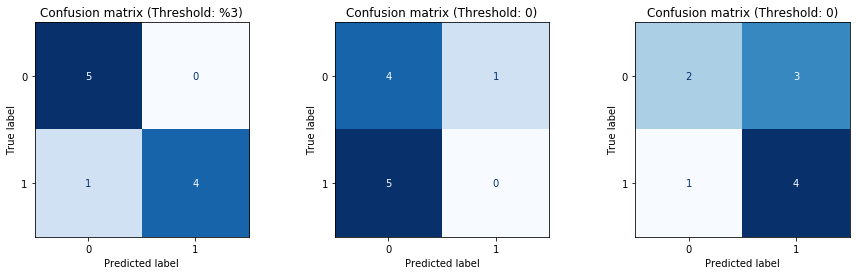

In [42]:
testBinary_labelsCNN = [1 if prob >= 0.5 else 0 for prob in y_scoresCNN] # Threshold: %3
testBinary_labelsAE = [1 if prob >= 0.5 else 0 for prob in y_scoresAE] # Threshold: %int()
testBinary_labelsVGG = [1 if prob >= 0.5 else 0 for prob in y_scoresVGG] # Threshold: %int()

# Assuming you have binary_labels0025, binary_labels0035, binary_labels004, binary_labels005, etc. already defined
# Define the thresholds for each binary label
thresholds = ['%3', int(), int()]
# Store all the binary labels in a list
binary_labels_list = [testBinary_labelsCNN, testBinary_labelsAE, testBinary_labelsVGG]
# In order to store the true negative, false positive, false negative and true positive
ravels = list()

# Set the number of subplots based on the number of thresholds
n_cols = 3
n_rows = int(np.ceil(len(thresholds) / n_cols))

# Create a figure to hold all the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the thresholds and plot each confusion matrix
for i, threshold in enumerate(thresholds):
    # Compute confusion matrix
    cm = confusion_matrix(y_test, binary_labels_list[i])
    # Unpack the confusion matrix into true negative, false positive, false negative and true positive
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    # Store the ravel in a list
    ravel = [true_neg, false_pos, false_neg, true_pos]
    ravels.append(ravel)
    
    # Initialize the display object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0", "1"])

    # Plot in the next subplot
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Confusion matrix (Threshold: {threshold})')

# Hide any unused subplots
for ax in axes[len(thresholds):]:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Add more space between the plots
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Show the plot
plt.show()

In [43]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set with the meta-learner
test_stacked_predictions = np.column_stack((testBinary_labelsCNN, testBinary_labelsAE, testBinary_labelsVGG))

# Predict on the test set with the meta-learner
meta_predictions = meta_learner.predict(stacked_predictions)

In [49]:
# Predicted probabilities for the test data
predicted_probabilities_test = meta_learner.predict_proba(stacked_predictions)

# Print the predicted probabilities for the test data
print(predicted_probabilities_test)

[[0.26607615 0.73392385]
 [0.26607615 0.73392385]
 [0.26607615 0.73392385]
 [0.26607615 0.73392385]
 [0.26607615 0.73392385]
 [0.7728447  0.2271553 ]
 [0.7728447  0.2271553 ]
 [0.7728447  0.2271553 ]
 [0.57829943 0.42170057]
 [0.7728447  0.2271553 ]]


In [48]:
print(meta_learner.predict_proba)

<bound method LogisticRegression.predict_proba of LogisticRegression()>


**Visualization in 3D**

In [ ]:
"""""""""""
#Visualize en 3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a dataframe with the meta-learner predictions
df = pd.DataFrame(stacked_predictions, columns=['CNN', 'AE', 'VGG'])
# Add the ground truth
df['Ground Truth'] = y_test
# Add the meta-learner predictions
df['Meta Learner'] = meta_predictions

# Create a PCA object
pca = PCA(n_components=3)
# Fit the PCA and transform the data
pca_features = pca.fit_transform(df[['CNN', 'AE', 'VGG']])
# Add the components to the dataframe
df['PCA1'] = pca_features[:, 0]
df['PCA2'] = pca_features[:, 1]
df['PCA3'] = pca_features[:, 2]

# Create a TSNE object
tsne = TSNE(n_components=3)
# Fit the TSNE and transform the data
tsne_features = tsne.fit_transform(df[['CNN', 'AE', 'VGG']])
# Add the components to the dataframe
df['TSNE1'] = tsne_features[:, 0]
df['TSNE2'] = tsne_features[:, 1]
df['TSNE3'] = tsne_features[:, 2]

# Create a scatter plot of the PCA features
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Ground Truth', style='Meta Learner', palette='Set2')
plt.title('PCA')
plt.show()

# Create a scatter plot of the TSNE features
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Ground Truth', style='Meta Learner', palette='Set2')
plt.title('TSNE')
plt.show()
""""""""


# Metrics for the aggregation function

Confusion matrix and classification report

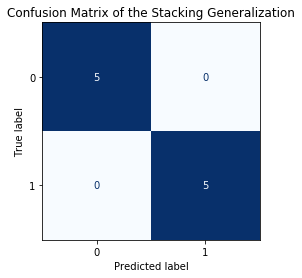

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["0", "1"])
disp.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix of the Stacking Generalization')
plt.show()
